# Projek Akhir Python for DS Hacktiv8
## Nicko Putra Hafizam
nicko.hafizam@gmail.com
1. Story-telling tentang data dari file training_text dan training_variants (se-kreatif mungkin)
2. Bikin model Klasifikasi, metode nya bebas

### Overview Project

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

### Data Description
There are nine different classes a genetic mutation can be classified on.

This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical for the success of your approach.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

## 1. Variants Data Insight

### 1.1 Library and Settings
Import library yang kita pakai: math, numpy, pandas, dsb.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### 1.2 Load Files & View Data
Import files dengan menyesuaikan pembatas kolomnya dan melihat sekilas data-data tsb.

In [2]:
train_text_df = pd.read_csv("training_text", sep="\|\|", engine='python',  # mendefinisikan separator '||' 
                            skiprows=1, names=["ID","Text"],               # menghapus header dan 1 row dari atas
                            index_col=0)                                   # menjadikan kolom ID sebagai Index
train_variants_df = pd.read_csv("training_variants")

print("Train Variant".ljust(15), train_variants_df.shape)   # menampilkan shape data dengan jarak tabulasi 15
print("Train Text".ljust(15), train_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 1)


In [3]:
train_text_df.head()   # menampilkan data text sekilas

,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
train_variants_df.head()  # menampilkan data variants sekilas

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_text_df.describe()

,Text
count,3316
unique,1920
top,The PTEN (phosphatase and tensin homolog) phos...
freq,53


Ditemukan bahwa data train_text memiliki jumlah count data 3316, dengan data unique sebanyak 1920

In [6]:
train_variants_df.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


Data train_variants memiliki jumlah data 3321, dan memiliki data unique Gen sebanyak 264, sedangkan Variation sebanyak 2996. Melihat jumlah data unique dari kolom Variation, cukup menarik perhatian.

### 1.3 Mengecek dan mengisi nilai Null

In [7]:
train_text_df.isna().sum()

Text    5
dtype: int64

Ditemukan terdapat 5 kolom teks yang kosong di data train_text. Kita akan mencoba mengisi kolom tersebut dengan fungsi fillna() disertai dengan data string kosong ''

In [8]:
text_df = train_text_df.fillna("")
print (text_df.isna().sum())

Text    0
dtype: int64


In [9]:
train_variants_df.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

Kembali kita cek isna(), dan kali ini semua kolom tidak lagi memiliki data yang kosong/null.

### 1.4 Melihat distribusi persebaran data

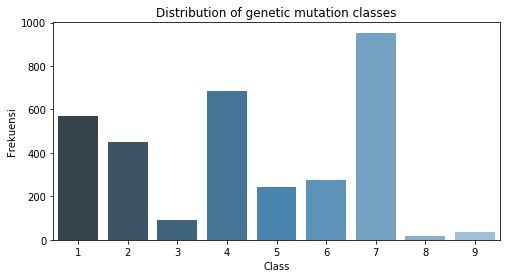

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(x="Class", data=train_variants_df, palette="Blues_d")
plt.ylabel('Frekuensi')
plt.xlabel('Class')
plt.title("Distribution of genetic mutation classes")
plt.show()

Melalui plot figur tersebut, dapat dilihat bahwa data train_variants didominasi oleh data class 7

### 1.5 Merging Dataframe

In [11]:
# melakukan concation kedua dataframe dengan merge
df_train = train_variants_df.merge(text_df, how="inner", left_on="ID", right_on="ID")

In [12]:
df_train.head(10)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...


Dilakukan penggabungan kedua dataframe.

### 1.6 Analisis pola data Unique

In [63]:
# Mencari berapa data unique dari kombinasi Gene + Variation
df_train['Gene_And_Variation']=df_train['Gene']+' '+df_train['Variation']
df_train['all_string']=df_train['Gene']+' '+df_train['Variation']+' '+df_train['Text']
df_train.head(20)

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count,all_string
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A Truncating Mutations,6089,FAM58A Truncating Mutations Cyclin-dependent k...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,CBL W802*,5722,CBL W802* Abstract Background Non-small cell...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,CBL Q249E,5722,CBL Q249E Abstract Background Non-small cell...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,CBL N454D,5572,CBL N454D Recent evidence has demonstrated tha...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,CBL L399V,6202,CBL L399V Oncogenic mutations in the monomeric...
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,CBL V391I,6202,CBL V391I Oncogenic mutations in the monomeric...
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,CBL V430M,6202,CBL V430M Oncogenic mutations in the monomeric...
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,CBL Deletion,14684,CBL Deletion CBL is a negative regulator of ac...
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,CBL Y371H,11923,CBL Y371H Abstract Juvenile myelomonocytic le...
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,CBL C384R,5721,CBL C384R Abstract Juvenile myelomonocytic le...


In [64]:
df_train.nunique()

ID                    3321
Gene                   264
Variation             2996
Class                    9
Text                  1921
Gene_And_Variation    3321
Text_count            1837
all_string            3321
dtype: int64

Ditemukan bahwa data train_variations merupakan kumpulan data dari kombinasi tiap Gene + Variations yang unique

In [15]:
gene_group = df_train.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences\n", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences\n", minimal_occ_genes)

Genes with maximal occurences
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


In [16]:
variation_group = df_train.groupby("Variation")['Variation'].count()
minimal_occ_Variation = variation_group.sort_values(ascending=True)[:10]
print("Variations with maximal occurences\n", variation_group.sort_values(ascending=False)[:10])
print("\nVariation with minimal occurences\n", minimal_occ_Variation)

Variations with maximal occurences
 Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
E17K                     3
T58I                     3
Q61L                     3
Q61R                     3
Name: Variation, dtype: int64

Variation with minimal occurences
 Variation
1_2009trunc    1
R133*          1
R133H          1
R1343L         1
R134Q          1
R1391G         1
R1391S         1
R139G          1
R140Q          1
R143Q          1
Name: Variation, dtype: int64


### 1.7 Menggambarkan grafik frekuensi tiap Class berdasarkan tipe Gene

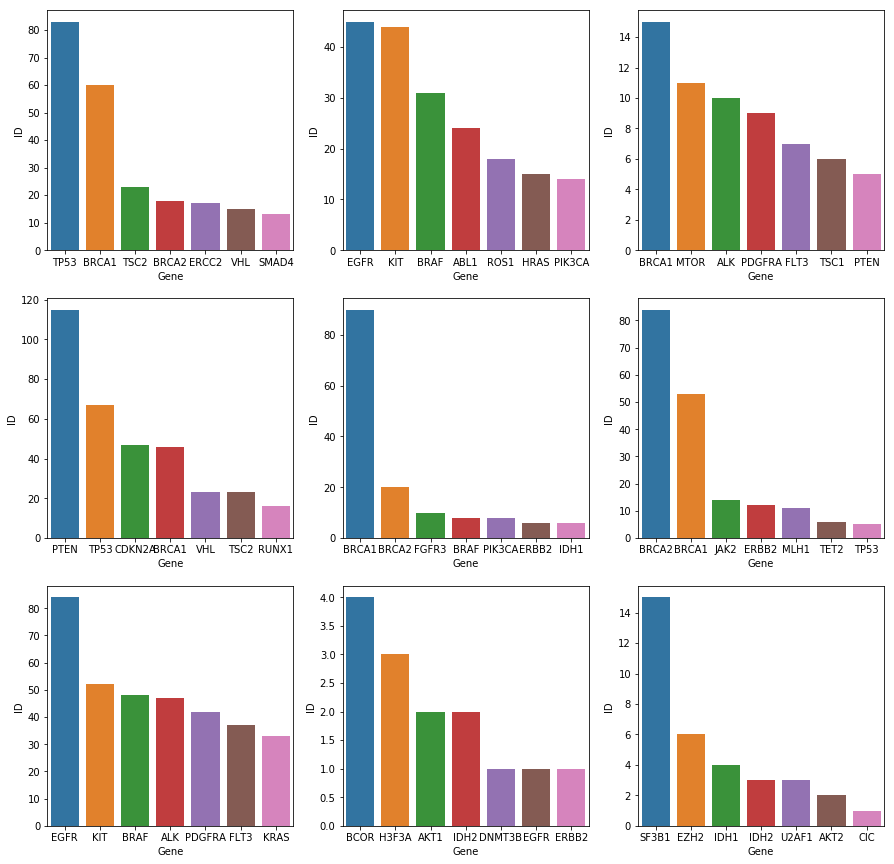

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_train[df_train["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

Melalui graphbar diatas, dapat dilihat frekuensi tipe gene terbanyak dari tiap class

## 2. Text Data Insight

### 2.1 Menambahkan data Text Count

In [18]:
# mencari dan menambahkan kolom text_count
df_train.loc[:, 'Text_count']  = df_train["Text"].apply(lambda x: len(x.split()))
df_train.head()

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A Truncating Mutations,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,CBL W802*,5722
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,CBL Q249E,5722
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,CBL N454D,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,CBL L399V,6202


Terdapat rows yang memiliki teks sama. Selanjutnya kita cek keunikan data text tersebut dan apakah teks yang sama dimiliki oleh class yang sama.

### 2.2 Analisis data Text berdasarkan uniqueness

In [19]:
count_grp = df_train.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,9444.702465,6513.641501,0.0,4970.00,7286.5,12868.25,52970.0
2,452.0,9306.362832,7624.322787,116.0,4184.25,6810.0,12209.50,61923.0
3,89.0,6751.157303,3724.432760,1737.0,4283.00,5572.0,7415.00,27371.0
4,686.0,8978.202624,7276.259637,53.0,4566.00,6351.0,11521.75,43893.0
5,242.0,7504.462810,3890.263510,183.0,5245.00,6451.0,9513.50,24214.0
6,275.0,7143.061818,3827.989093,0.0,4505.50,6587.0,7626.00,24597.0
7,953.0,11437.910808,10105.203783,0.0,4871.00,8254.0,14620.00,76708.0
8,19.0,10810.105263,5645.073662,2111.0,5586.00,11237.0,15535.00,20612.0
9,37.0,12798.567568,10208.668344,1146.0,4942.00,10917.0,15797.00,45126.0


In [20]:
df_train[df_train["Text_count"]<500.0]

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count
140,140,EGFR,I491M,5,The accurate determination of perfluoroalkyl s...,EGFR I491M,430
145,145,EGFR,K467T,2,The accurate determination of perfluoroalkyl s...,EGFR K467T,430
259,259,EGFR,S464L,2,The accurate determination of perfluoroalkyl s...,EGFR S464L,430
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,CDH1 A617T,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,CDH1 A634V,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,CDH1 T340A,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",CDKN2A Q50*,103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,CDKN2A R79P,228
692,692,CDKN2A,G93W,4,Cell division is controlled by a series of pos...,CDKN2A G93W,228
693,693,CDKN2A,V118D,4,Cell division is controlled by a series of pos...,CDKN2A V118D,228


Kita lihat bahwa satu jenis teks dapat mendefinisikan class yang berbeda.

### 2.3 Distribusi Text Count terhadap class

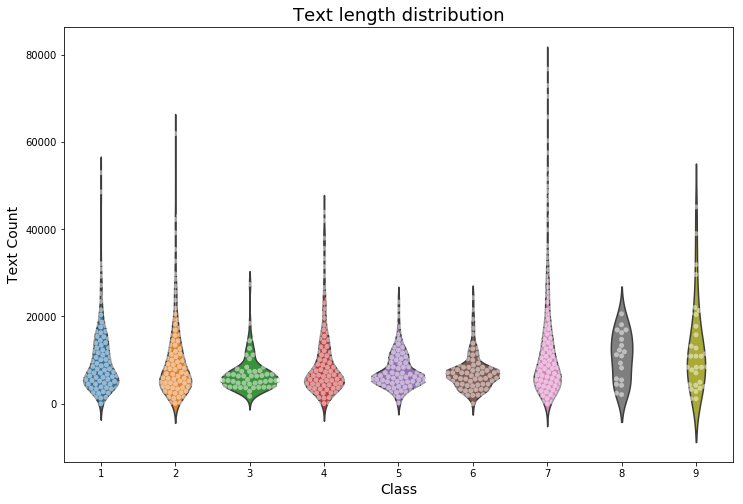

In [21]:
plt.figure(figsize=(12,8))
gene_count_grp = df_train.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=df_train, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=df_train, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

All classes have most counts in between 0 to 20000.

### 2.4 Mencari Frekuensi Istilah yang sering muncul dalam tiap class

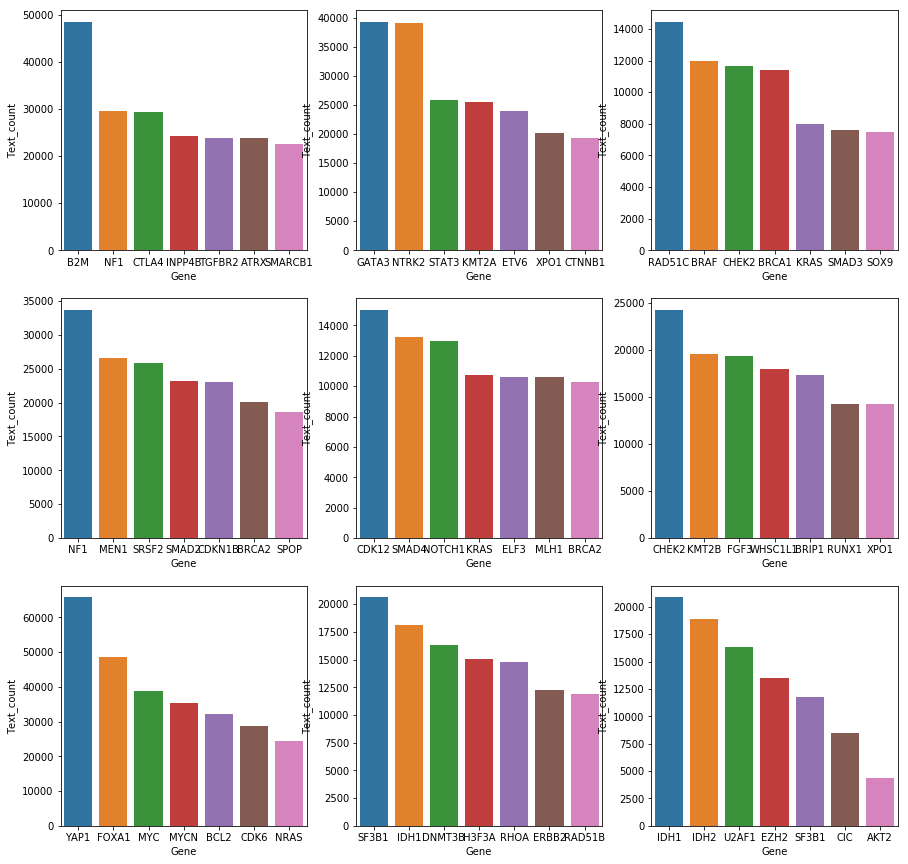

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_train[df_train["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

### 2.5 Men-generate feature dari data Text terhadap class dengan TFIDF

In [23]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

Kemudian kita plotting

In [24]:
tfidf = TfidfVectorizer(
	min_df=5, max_features=16000, strip_accents='unicode',lowercase =True,
	analyzer='word', token_pattern=r'\w+', use_idf=True, 
	smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(df_train["Text"])

Xtr = tfidf.fit_transform(df_train["Text"])
y = df_train["Class"]
features = tfidf.get_feature_names()
top_dfs = top_feats_by_class(Xtr, y, features)

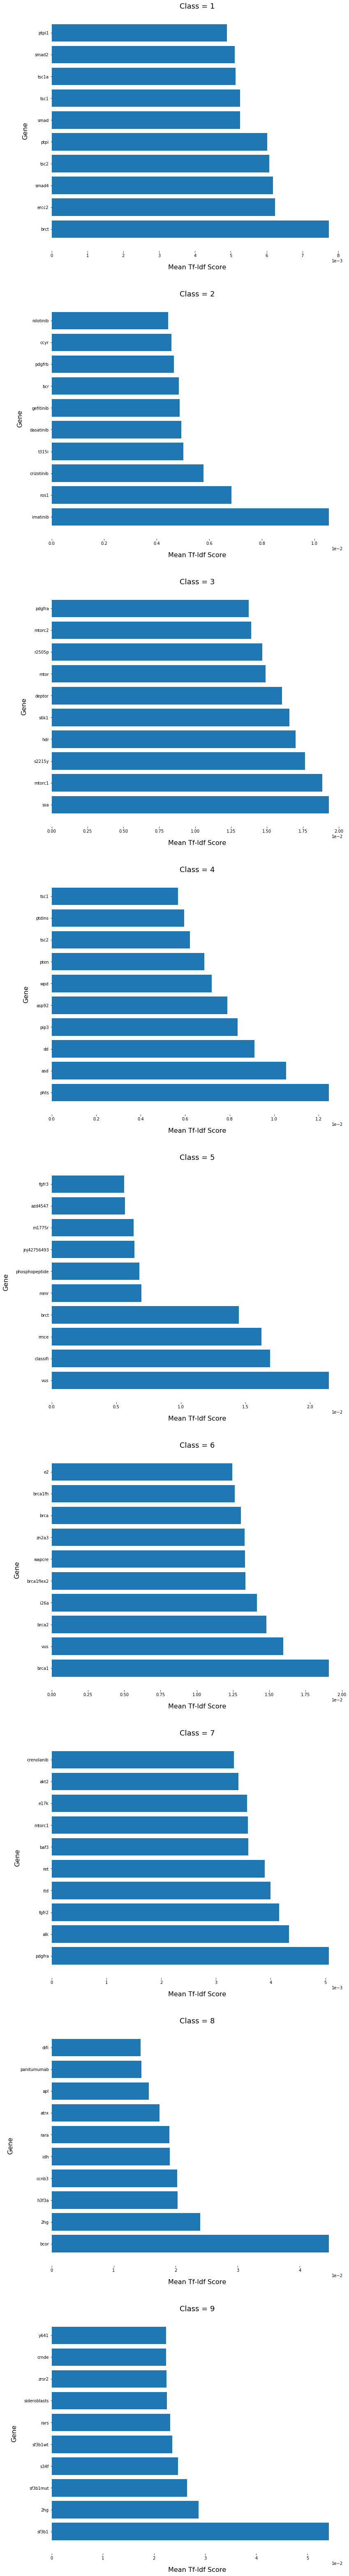

In [25]:
plot_tfidf_classfeats_h(top_dfs)

Didapatkan hasil nilai rata-rata tf-idf dari data text berdasarkan distribusi class.

### 2.6 Menampilkan Wordcloud

In [26]:
# import library wordcloud
from wordcloud import WordCloud, STOPWORDS

In [27]:
# menambah stopwords
STOPWORDS.add('et')
STOPWORDS.add('al')
STOPWORDS.add('â')
STOPWORDS.add('Figure')
STOPWORDS.add('figure')
STOPWORDS.add('fig')
STOPWORDS.add('Supplementary')

In [28]:
# Separasi tiap class
class1DF = df_train[df_train.Class == 1]
class2DF = df_train[df_train.Class == 2]
class3DF = df_train[df_train.Class == 3]
class4DF = df_train[df_train.Class == 4]
class5DF = df_train[df_train.Class == 5]
class6DF = df_train[df_train.Class == 6]
class7DF = df_train[df_train.Class == 7]
class8DF = df_train[df_train.Class == 8]
class9DF = df_train[df_train.Class == 9]

In [29]:
# mengkonversi tiap class menjadi string
class1 = class1DF['Text'].tolist()
string1 = ''
for i in range(len(class1)):
    string1 += class1[i]

class2 = class2DF['Text'].tolist()
string2 = ''
for i in range(len(class2)):
    string2 += class2[i]

class3 = class3DF['Text'].tolist()
string3 = ''
for i in range(len(class3)):
    string3 += class3[i]

class4 = class4DF['Text'].tolist()
string4 = ''
for i in range(len(class4)):
    string4 += class4[i]

class5 = class5DF['Text'].tolist()
string5 = ''
for i in range(len(class5)):
    string5 += class5[i]

class6 = class6DF['Text'].tolist()
string6 = ''
for i in range(len(class6)):
    string6 += class6[i]

class7 = class7DF['Text'].tolist()
string7 = ''
for i in range(len(class7)):
    string7 += class7[i]

class8 = class8DF['Text'].tolist()
string8 = ''
for i in range(len(class8)):
    string8 += class8[i]

class9 = class9DF['Text'].tolist()
string9 = ''
for i in range(len(class9)):
    string9 += class9[i]

In [30]:
# Generate wordcloud
wordcloud1 = WordCloud(   stopwords=STOPWORDS,
                          background_color='black',

                       max_words=25
                         ).generate(string1)

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string2)

wordcloud3 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string3)

wordcloud4 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string4)

wordcloud5 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string5)

wordcloud6 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string6)

wordcloud7 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string7)

wordcloud8 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string8)

wordcloud9 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',

                        max_words=25
                         ).generate(string9)

Class 1


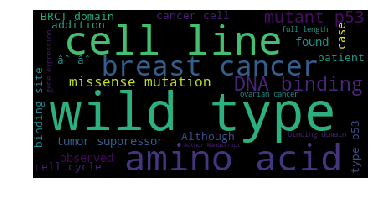

Class 2


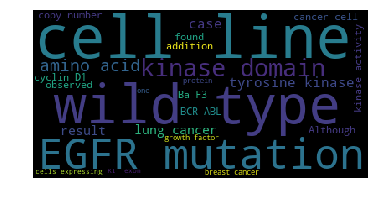

Class 3


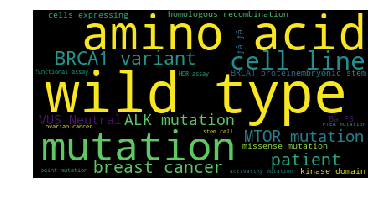

Class 4


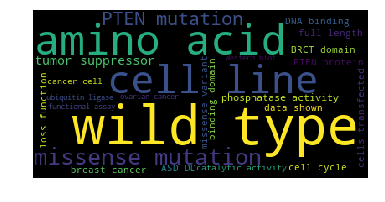

Class 5


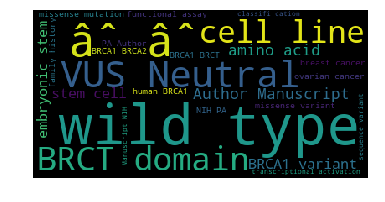

Class 6


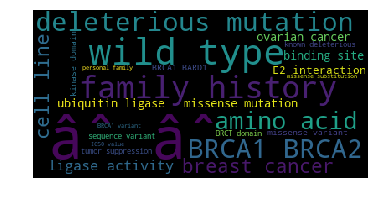

Class 7


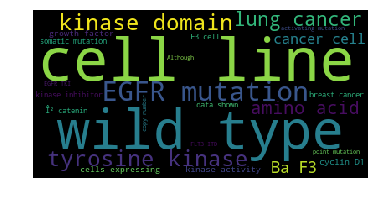

Class 8


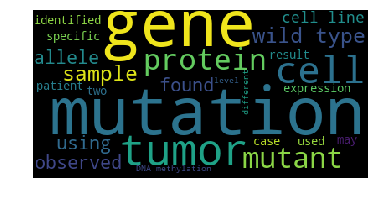

Class 9


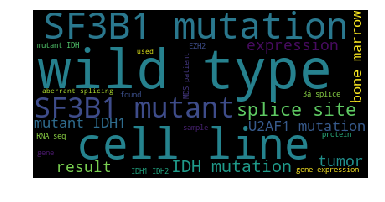

In [31]:
# plot wordcloud
print("Class 1")
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

print("Class 2")
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

print("Class 3")
plt.imshow(wordcloud3)
plt.axis('off')
plt.show()

print("Class 4")
plt.imshow(wordcloud4)
plt.axis('off')
plt.show()

print("Class 5")
plt.imshow(wordcloud5)
plt.axis('off')
plt.show()

print("Class 6")
plt.imshow(wordcloud6)
plt.axis('off')
plt.show()

print("Class 7")
plt.imshow(wordcloud7)
plt.axis('off')
plt.show()

print("Class 8")
plt.imshow(wordcloud8)
plt.axis('off')
plt.show()

print("Class 9")
plt.imshow(wordcloud9)
plt.axis('off')
plt.show()

## 3. Machine Learning with TF-IDF Method

In [100]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=5, max_features=16000, 
    strip_accents='unicode', lowercase=True,
    analyzer='word', token_pattern=r'\w+', 
    # ngram_range=(1, 3), 
    use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english'
)
tfidf_vectorizer.fit(df_train['all_string'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=16000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

### 3.1 Split Data Test

In [112]:
from sklearn.model_selection import train_test_split
X = df_train.all_string
y = df_train.Class
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=8)

In [113]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2490,)
(831,)
(2490,)
(831,)


## 4. Training

In [114]:
# SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', svm.LinearSVC())
])
text_clf = text_clf.fit(X_train,y_train)

In [115]:
y_test_predicted = text_clf.predict(X_test)
np.mean(y_test_predicted == y_test)

0.6389891696750902

In [119]:
X_test_final = df_train['all_string'].values
predicted_class = text_clf.predict(X_test_final)
df_train['predicted_class'] = predicted_class

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count,all_string,predicted_class
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A Truncating Mutations,6089,FAM58A Truncating Mutations Cyclin-dependent k...,1
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,CBL W802*,5722,CBL W802* Abstract Background Non-small cell...,2
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,CBL Q249E,5722,CBL Q249E Abstract Background Non-small cell...,2
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,CBL N454D,5572,CBL N454D Recent evidence has demonstrated tha...,4
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,CBL L399V,6202,CBL L399V Oncogenic mutations in the monomeric...,4


In [120]:
df_train.head(10)

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count,all_string,predicted_class
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A Truncating Mutations,6089,FAM58A Truncating Mutations Cyclin-dependent k...,1
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,CBL W802*,5722,CBL W802* Abstract Background Non-small cell...,2
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,CBL Q249E,5722,CBL Q249E Abstract Background Non-small cell...,2
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,CBL N454D,5572,CBL N454D Recent evidence has demonstrated tha...,4
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,CBL L399V,6202,CBL L399V Oncogenic mutations in the monomeric...,4
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,CBL V391I,6202,CBL V391I Oncogenic mutations in the monomeric...,4
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,CBL V430M,6202,CBL V430M Oncogenic mutations in the monomeric...,4
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,CBL Deletion,14684,CBL Deletion CBL is a negative regulator of ac...,1
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,CBL Y371H,11923,CBL Y371H Abstract Juvenile myelomonocytic le...,4
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,CBL C384R,5721,CBL C384R Abstract Juvenile myelomonocytic le...,4


## 5. Create Submission File

In [122]:
# Onehot encoding to get the predicted values as columns
onehot = pd.get_dummies(df_train['predicted_class'])
df_train_final = df_train.join(onehot)
df_train_final.head(5)

,ID,Gene,Variation,Class,Text,Gene_And_Variation,Text_count,all_string,predicted_class,1,2,3,4,5,6,7,8,9
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A Truncating Mutations,6089,FAM58A Truncating Mutations Cyclin-dependent k...,1,1,0,0,0,0,0,0,0,0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,CBL W802*,5722,CBL W802* Abstract Background Non-small cell...,2,0,1,0,0,0,0,0,0,0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,CBL Q249E,5722,CBL Q249E Abstract Background Non-small cell...,2,0,1,0,0,0,0,0,0,0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,CBL N454D,5572,CBL N454D Recent evidence has demonstrated tha...,4,0,0,0,1,0,0,0,0,0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,CBL L399V,6202,CBL L399V Oncogenic mutations in the monomeric...,4,0,0,0,1,0,0,0,0,0


In [123]:
submission_df = df_train_final[["ID",1,2,3,4,5,6,7,8,9]]
submission_df.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
submission_df.head(5)

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0
4,4,0,0,0,1,0,0,0,0,0


## Reference & Acknowledgement

1. Adarsh Nair. Brief insight on Genetic variations. 
https://www.kaggle.com/dextrousjinx/brief-insight-on-genetic-variations

2. Ekaterina AvdeevaCancer. All 'Gene + Variation' values are unique. 
https://www.kaggle.com/eavdeeva/cancer-all-gene-variation-values-are-unique

3. James. WordClouds for Each Class. 
https://www.kaggle.com/mogwai/wordclouds-for-each-class

4. Pamin Rangsikunpum. Basic TF-IDF Models Evaluation. 
https://www.kaggle.com/pamin2222/basic-tf-idf-models-evaluation

5. Bhuvaneshwaran K. Redefining Cancer Treatment - Linear SVC. 
https://www.kaggle.com/bhuvaneshwaran/redefining-cancer-treatment-linear-svc

Special Thanks to

- Mas Afif AI: http://ngodingpython.com/
- Tim 'Belajar Kelompok': Mas Artha, Mas Suryo, Mas Febri
- Teman-teman kelas Intro Data Science Hacktivate Batch 5
- Hacktivate



--- SELESAI ---